In [250]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [251]:
import numpy as np
import pandas as pd

In [252]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [253]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [254]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [255]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [127]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [128]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [129]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Table Inspect and exploration

In [130]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [131]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [132]:
#  column names & types in the 'measurement' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [133]:
#  column names & types in the 'station' table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Reflected Class exploration

### Measurement is a base blass that was created by the Reflection

In [134]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c3bf58c3c8>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

### Station is a base blass that was created by the Reflection

In [135]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c3bf2d1978>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [136]:
### query experiments
for row in session.query(Measurement.prcp, Measurement.date, Measurement.station).limit(5).all():
    print(row)

(0.08, '2010-01-01', 'USC00519397')
(0.0, '2010-01-02', 'USC00519397')
(0.0, '2010-01-03', 'USC00519397')
(0.0, '2010-01-04', 'USC00519397')
(None, '2010-01-06', 'USC00519397')


In [137]:
for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude).all():
    print(row)

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025)


# Exploratory Climate Analysis

In [138]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [139]:
# Calculate the date 1 year ago from the last data point in the database
# https://stackoverflow.com/questions/2803852/python-date-string-to-date-object 

lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(lastDate, type(lastDate))

lastDate = dt.datetime.strptime((session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]), '%Y-%m-%d').date()
print(lastDate, type(lastDate))

#12 months ago
yearAgoDate = lastDate - dt.timedelta(weeks=52)
print(yearAgoDate, type(yearAgoDate))


2017-08-23 <class 'str'>
2017-08-23 <class 'datetime.date'>
2016-08-24 <class 'datetime.date'>


In [174]:
# Perform a query to retrieve the data and precipitation scores
prcpQuery = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= yearAgoDate)

# for row in prcpQuery :
#     print(row);

In [178]:
# Save the query prcpResults as a Pandas DataFrame and set the index to the date column
prcpResults_df = pd.read_sql(prcpQuery.statement, engine)

prcpResults_df.set_index('date', inplace=True)
prcpResults_df.dropna(inplace=True)
prcpResults_df

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


In [179]:
# Sort the dataframe by date
prcpResults_df.sort_index(ascending=True, kind='mergesort', inplace=True)
#prcpResults_df.sort_index(ascending=True, inplace=True)

In [182]:
#prcpResults_df[300:400]

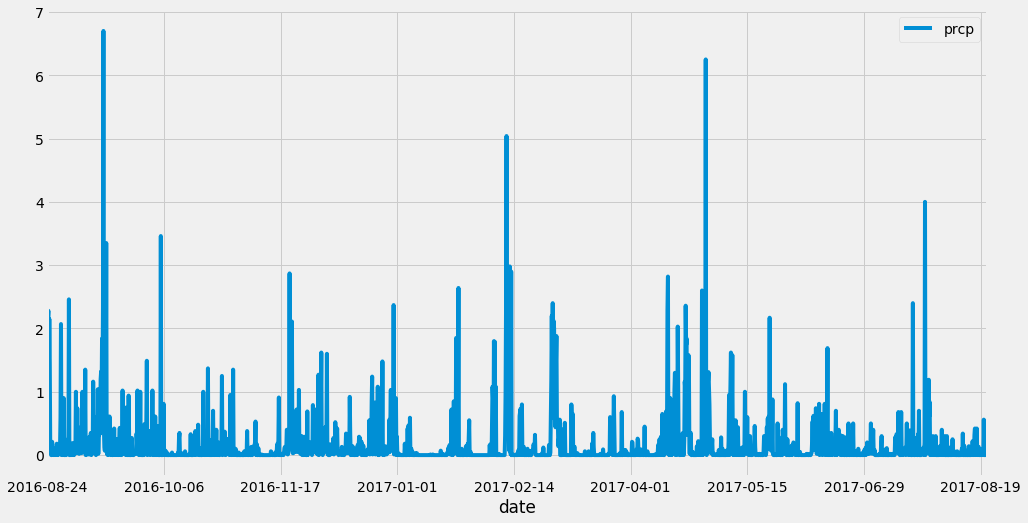

In [183]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpResults_df.plot(figsize=(15,8))

![precipitation](Images/precipitation.png)

In [184]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpResults_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [193]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"Station Count = {stationCount}")

Station Count = 9


In [212]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#stationCount = session.query(Measurement.station).group_by(Measurement.station).count()

# session.query(Measurement.station, func.count(Measurement.station)).\
#     group_by(Measurement.station).\
#     order_by(func.count(Measurement.station).desc()).all()

session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [210]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    group_by(Measurement.station). \
    filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

TypeError: 'str' object is not callable

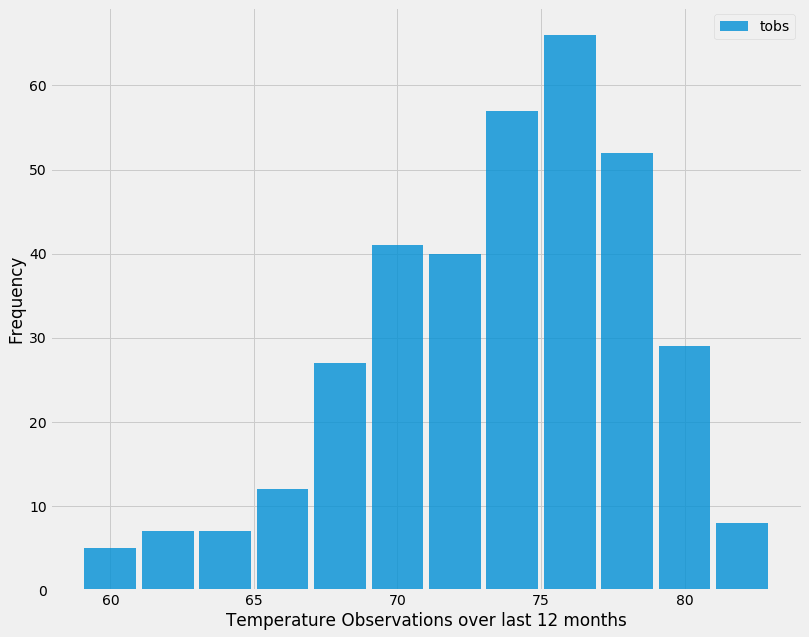

In [256]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsQuery = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281'). \
    filter(Measurement.date >= yearAgoDate)

tobsResults_df = pd.read_sql(tobsQuery.statement, engine)

tobsResults_df.set_index('date', inplace=True)
tobsResults_df.dropna(inplace=True)
tobsResults_df

#fig, ax = plt.subplots()
tobsResults_df.plot.hist(bins=12, alpha = 0.8, figsize=(12,10), grid=True, rwidth=0.9)
plt.xlabel("Temperature Observations over last 12 months")
plt.title('Station: USC00519281')
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


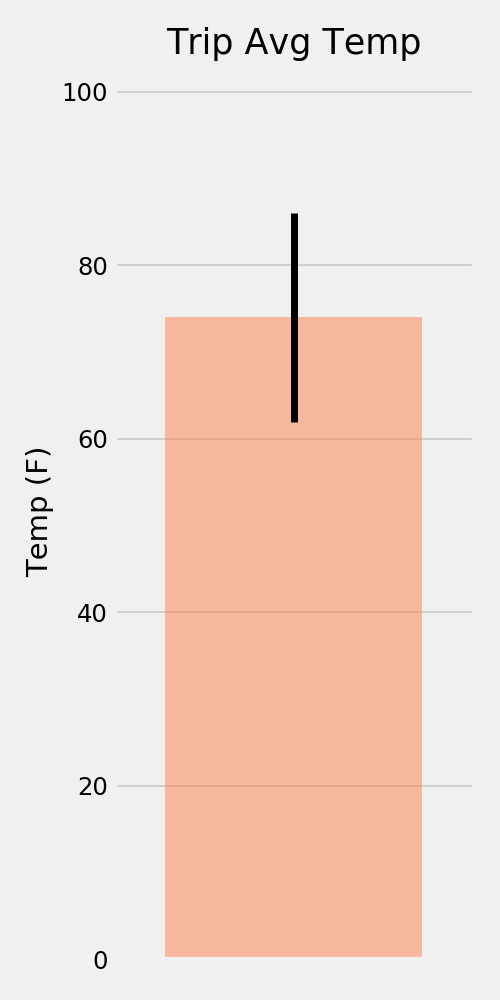

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


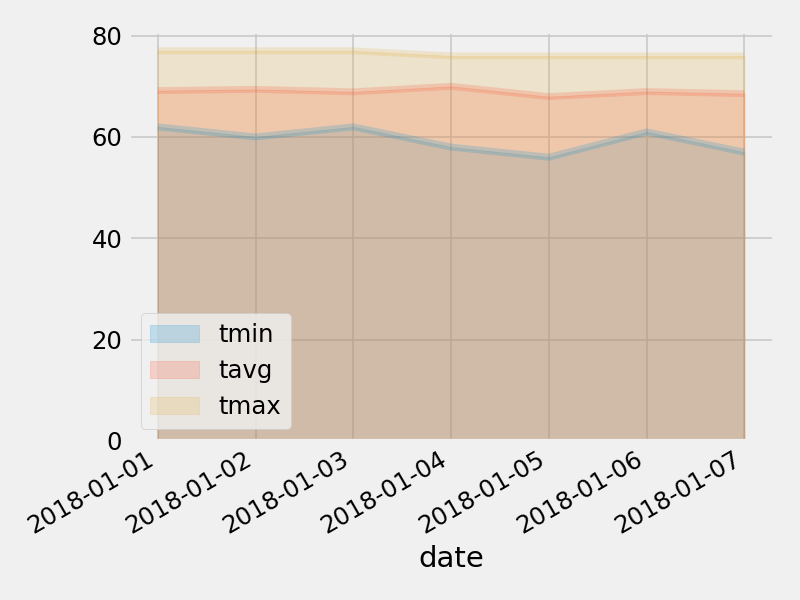

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
